In [34]:
import pandas as pd
import nltk
import spacy
import seaborn as sns
import numpy as np

from tqdm import tqdm
from matplotlib import pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
pd.options.plotting.backend = "matplotlib"

In [3]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [4]:
df_train.tail(20)

,id,keyword,location,text,target
7593,10848,NaN,NaN,I just heard a really loud bang and everyone i...,0
7594,10849,NaN,NaN,A gas thing just exploded and I heard screams ...,1
7595,10850,NaN,NaN,NWS: Flash Flood Warning Continued for Shelby ...,1
7596,10851,NaN,NaN,RT @LivingSafely: #NWS issues Severe #Thunders...,1
7597,10852,NaN,NaN,#??? #?? #??? #??? MH370: Aircraft debris foun...,1
7598,10853,NaN,NaN,Father-of-three Lost Control of Car After Over...,1
7599,10854,NaN,NaN,1.3 #Earthquake in 9Km Ssw Of Anza California ...,1
7600,10855,NaN,NaN,Evacuation order lifted for town of Roosevelt:...,1
7601,10859,NaN,NaN,#breaking #LA Refugio oil spill may have been ...,1
7602,10860,NaN,NaN,a siren just went off and it wasn't the Forney...,1


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
df_train.dropna(inplace=True)

In [7]:
df_train.describe()

,id,target
count,5080.000000,5080.000000
mean,5407.112598,0.432283
std,3116.359041,0.495442
min,48.000000,0.000000
25%,2728.750000,0.000000
50%,5360.500000,0.000000
75%,8086.000000,1.000000
max,10833.000000,1.000000


<AxesSubplot:>

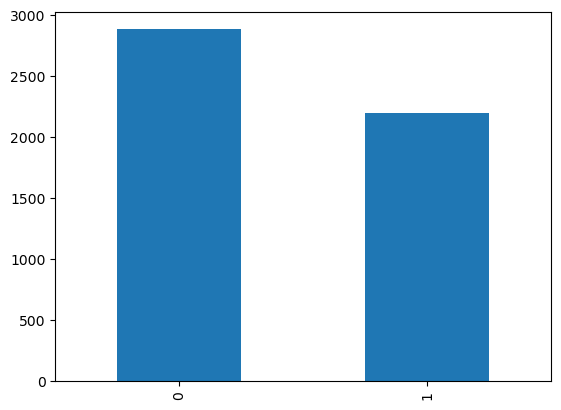

In [8]:
df_train.target.value_counts().plot(kind='bar')

In [9]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gabrielroger/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
snlp = spacy.load('en_core_web_sm')

In [11]:
def lemmatizer(text):
    result = [word.lemma_ for word in snlp(text)]
    return " ".join(result)

In [12]:
def lemmatizer_verbs(text):
    sent = []
    doc = nlp(text)
    for word in doc:
        if word.pos_ == "VERB":
            sent.append(word.lemma_)
        else:
            sent.append(word.text)
    return " ".join(sent)

In [13]:
def preprocess(df):
    df['text_lemma'] = df.text.apply(lemmatizer)
    df['text_lemma_verbs'] = df.text.apply(lemmatizer)
    return df

In [14]:
stopwords = list(set(snlp.Defaults.stop_words).union(set(nltk.corpus.stopwords.words('english'))))

In [15]:
df_train = preprocess(df_train)

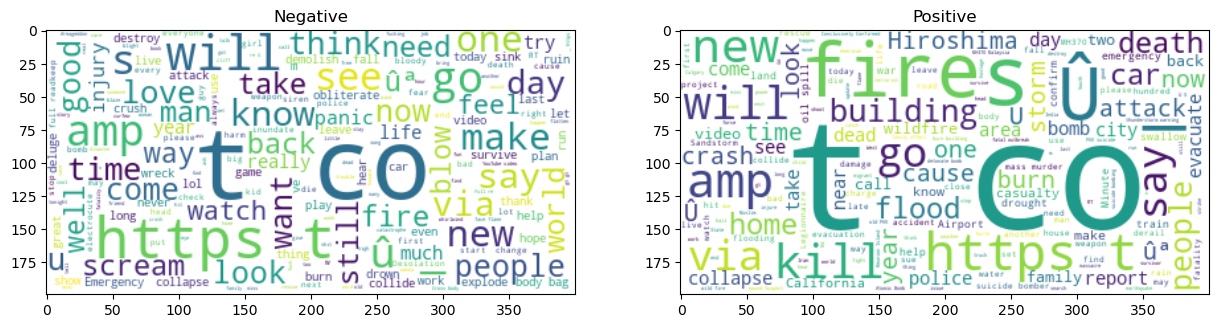

In [16]:
negative_cases = "".join(df_train[df_train['target'] == 0]['text_lemma_verbs'].values)
positive_cases = "".join(df_train[df_train['target'] == 1]['text_lemma_verbs'].values)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))

wc1 = WordCloud(background_color='white').generate(negative_cases)
wc2 = WordCloud(background_color='white').generate(positive_cases)

axs[0].imshow(wc1, interpolation='bilinear')
axs[0].set_title('Negative')
axs[1].imshow(wc2, interpolation='bilinear')
axs[1].set_title('Positive')

plt.show()

In [17]:
X = df_train.text_lemma_verbs
y = df_train['target'].values

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3556,), (1524,), (3556,), (1524,))

# Count Vectorizer & Random Forest

In [19]:
rf_pipeline = Pipeline([
    ('CountVectorizer', CountVectorizer(stop_words=stopwords)),
    ('rf', RandomForestClassifier(random_state=42))
])

In [20]:
rf_pipeline.fit(X_train, y_train) 

Pipeline(steps=[('CountVectorizer',
                 CountVectorizer(stop_words=['very', "it's", 'whereupon',
                                             "couldn't", 'couldn', 'between',
                                             'us', 'amongst', "you're",
                                             'because', 'part', "shouldn't",
                                             'really', "she's", 'aren', 'isn',
                                             'seeming', 're', 'were', "that'll",
                                             'go', 'hers', 'moreover', 'every',
                                             'off', 'against', 'shouldn',
                                             'much', 'becoming', 'those', ...])),
                ('rf', RandomForestClassifier(random_state=42))])

In [21]:
y_pred = rf_pipeline.predict(X_test)

In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.92      0.83       884
           1       0.84      0.58      0.69       640

    accuracy                           0.78      1524
   macro avg       0.80      0.75      0.76      1524
weighted avg       0.79      0.78      0.77      1524



In [23]:
print(accuracy_score(y_test, y_pred))

0.7775590551181102


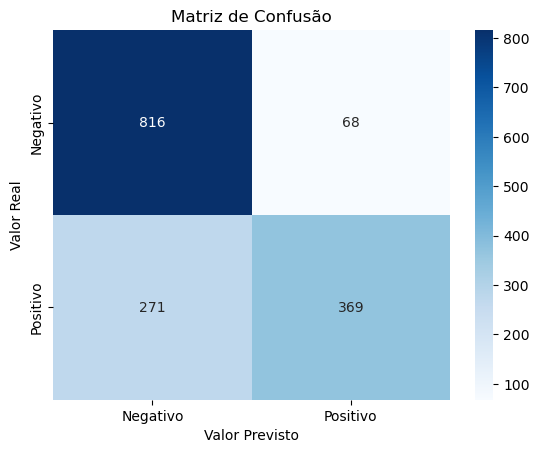

In [24]:
cnf_matrix = confusion_matrix(y_test, y_pred)
cmap = sns.color_palette("Blues", as_cmap=True)
sns.heatmap(cnf_matrix, annot=True, fmt='g', cmap=cmap, 
            xticklabels=['Negativo', 'Positivo'], 
            yticklabels=['Negativo', 'Positivo'])

plt.title('Matriz de Confusão')
plt.xlabel('Valor Previsto')
plt.ylabel('Valor Real')
plt.show()

# TFIDF & RF

              precision    recall  f1-score   support

           0       0.75      0.90      0.82       884
           1       0.81      0.60      0.69       640

    accuracy                           0.77      1524
   macro avg       0.78      0.75      0.75      1524
weighted avg       0.78      0.77      0.76      1524

0.7723097112860893


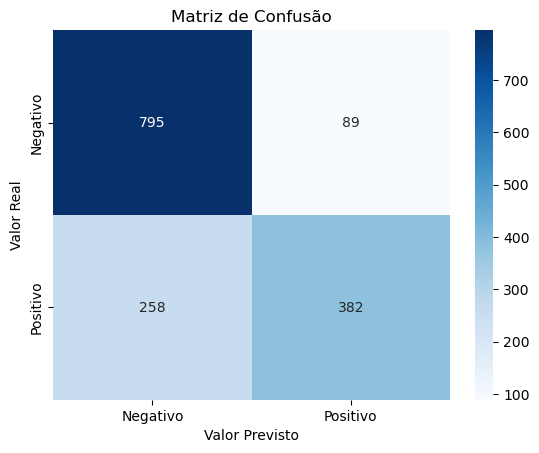

In [25]:
rf_pipeline2 = Pipeline([
    ('TFIDF', TfidfVectorizer(stop_words=stopwords)),
    ('rf', RandomForestClassifier(random_state=42))
])

rf_pipeline2.fit(X_train, y_train) 
y_pred2 = rf_pipeline2.predict(X_test)

print(classification_report(y_test, y_pred2))
print(accuracy_score(y_test, y_pred2))

cnf_matrix = confusion_matrix(y_test, y_pred2)
cmap = sns.color_palette("Blues", as_cmap=True)
sns.heatmap(cnf_matrix, annot=True, fmt='g', cmap=cmap, 
            xticklabels=['Negativo', 'Positivo'], 
            yticklabels=['Negativo', 'Positivo'])

plt.title('Matriz de Confusão')
plt.xlabel('Valor Previsto')
plt.ylabel('Valor Real')
plt.show()

# SVC & TFIDF

              precision    recall  f1-score   support

           0       0.81      0.79      0.80       884
           1       0.72      0.74      0.73       640

    accuracy                           0.77      1524
   macro avg       0.77      0.77      0.77      1524
weighted avg       0.77      0.77      0.77      1524

0.7716535433070866


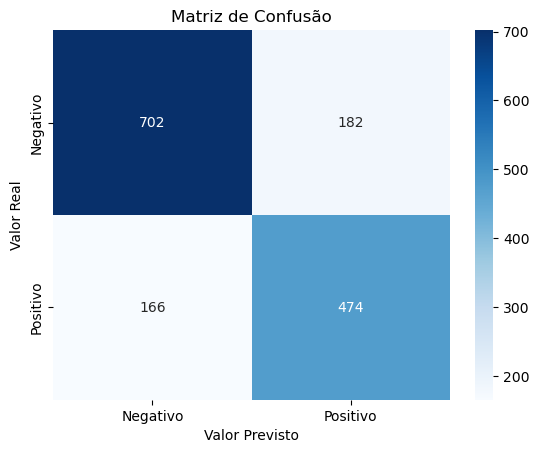

In [26]:
svc = Pipeline([
    ('TFIDF', TfidfVectorizer(stop_words=stopwords)),
    ('rf', LinearSVC(random_state=42))
])

svc.fit(X_train, y_train) 
y_pred3 = svc.predict(X_test)

print(classification_report(y_test, y_pred3))
print(accuracy_score(y_test, y_pred3))

cnf_matrix = confusion_matrix(y_test, y_pred3)
cmap = sns.color_palette("Blues", as_cmap=True)
sns.heatmap(cnf_matrix, annot=True, fmt='g', cmap=cmap, 
            xticklabels=['Negativo', 'Positivo'], 
            yticklabels=['Negativo', 'Positivo'])

plt.title('Matriz de Confusão')
plt.xlabel('Valor Previsto')
plt.ylabel('Valor Real')
plt.show()

# XGB

              precision    recall  f1-score   support

           0       0.76      0.87      0.81       884
           1       0.77      0.62      0.69       640

    accuracy                           0.76      1524
   macro avg       0.77      0.74      0.75      1524
weighted avg       0.77      0.76      0.76      1524

0.7644356955380578


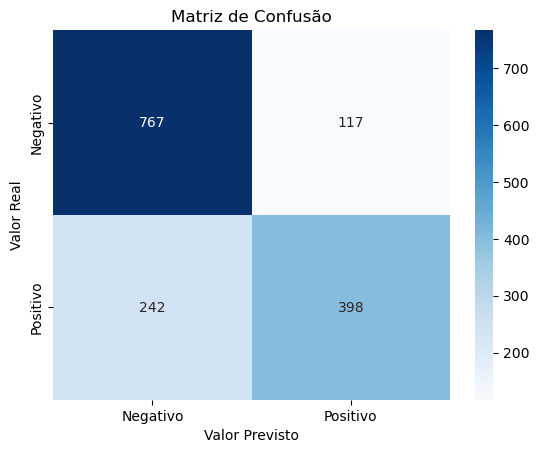

In [32]:
xgb = Pipeline([
    ('TFIDF', CountVectorizer(stop_words=stopwords, max_features=1000)),
    ('xbg', XGBClassifier(random_state=42, max_depth=5, n_estimators=100, ))
])

xgb.fit(X_train, y_train) 
y_pred4 = xgb.predict(X_test)

print(classification_report(y_test, y_pred4))
print(accuracy_score(y_test, y_pred4))

cnf_matrix = confusion_matrix(y_test, y_pred4)
cmap = sns.color_palette("Blues", as_cmap=True)
sns.heatmap(cnf_matrix, annot=True, fmt='g', cmap=cmap, 
            xticklabels=['Negativo', 'Positivo'], 
            yticklabels=['Negativo', 'Positivo'])

plt.title('Matriz de Confusão')
plt.xlabel('Valor Previsto')
plt.ylabel('Valor Real')
plt.show()

In [31]:
params_to_search = {
    'TFIDF__max_features': [500, 1000, 2000],
    'xbg__max_depth': [3, 5, 7],
    'xbg__n_estimators': [100, 500, 1000]
}

grid = GridSearchCV(xgb, param_grid=params_to_search, cv=5)
grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

{'TFIDF__max_features': 1000, 'xbg__max_depth': 5, 'xbg__n_estimators': 100}
0.7741893045086047


# POLARITY with NLTK

In [35]:
sid = SentimentIntensityAnalyzer()

In [37]:
df_train['scores_nltk'] = df_train['text'].apply(lambda x: sid.polarity_scores(x))

In [43]:
df_train.scores_nltk.head(0)

Series([], Name: scores_nltk, dtype: object)

In [39]:
df_train['compound']  = df_train['scores_nltk'].apply(lambda score_dict: score_dict['compound'])

In [41]:
df_train['comp_score'] = df_train['compound'].apply(lambda x: 1 if x >=0 else 0)

In [42]:
accuracy_score(df_train['target'],df_train['comp_score'])

0.43326771653543306

In [45]:
print(classification_report(df_train['target'],df_train['comp_score']))

              precision    recall  f1-score   support

           0       0.50      0.44      0.47      2884
           1       0.37      0.42      0.39      2196

    accuracy                           0.43      5080
   macro avg       0.43      0.43      0.43      5080
weighted avg       0.44      0.43      0.44      5080



# Submit dataset

In [53]:
df_test = preprocess(df_test)

In [54]:
y_pred_test = rf_pipeline2.predict(df_test.text_lemma)

In [55]:
y_pred_test

array([0, 1, 0, ..., 1, 1, 0])

In [56]:
df_test

,id,keyword,location,text,text_lemma,text_lemma_verbs
0,0,NaN,NaN,Just happened a terrible car crash,just happen a terrible car crash,just happen a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...","hear about # earthquake be different city , st...","hear about # earthquake be different city , st..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...","there be a forest fire at spot pond , geese be...","there be a forest fire at spot pond , geese be..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting . # spokane # wildfire,apocalypse lighting . # spokane # wildfire
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,Typhoon Soudelor kill 28 in China and Taiwan,Typhoon Soudelor kill 28 in China and Taiwan
...,...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,earthquake safety LOS ANGELES ûò SAFETY faste...,earthquake safety LOS ANGELES ûò SAFETY faste...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,storm in RI bad than last hurricane . my city&...,storm in RI bad than last hurricane . my city&...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,Green Line derailment in Chicago http://t.co/U...,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,meg issue Hazardous Weather Outlook ( HWO ) ht...,meg issue Hazardous Weather Outlook ( HWO ) ht...


In [69]:
df_new = pd.DataFrame({'id': df_test['id'], 'target': list(y_pred_test)})

In [70]:
df_new.target.value_counts()

0    2285
1     978
Name: target, dtype: int64

In [71]:
df_new.shape

(3263, 2)

In [72]:
df_test2 = df_test.merge(df_new)

In [73]:
df_test2.head()

,id,keyword,location,text,text_lemma,text_lemma_verbs,target
0,0,NaN,NaN,Just happened a terrible car crash,just happen a terrible car crash,just happen a terrible car crash,0
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...","hear about # earthquake be different city , st...","hear about # earthquake be different city , st...",1
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...","there be a forest fire at spot pond , geese be...","there be a forest fire at spot pond , geese be...",0
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting . # spokane # wildfire,apocalypse lighting . # spokane # wildfire,0
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,Typhoon Soudelor kill 28 in China and Taiwan,Typhoon Soudelor kill 28 in China and Taiwan,1


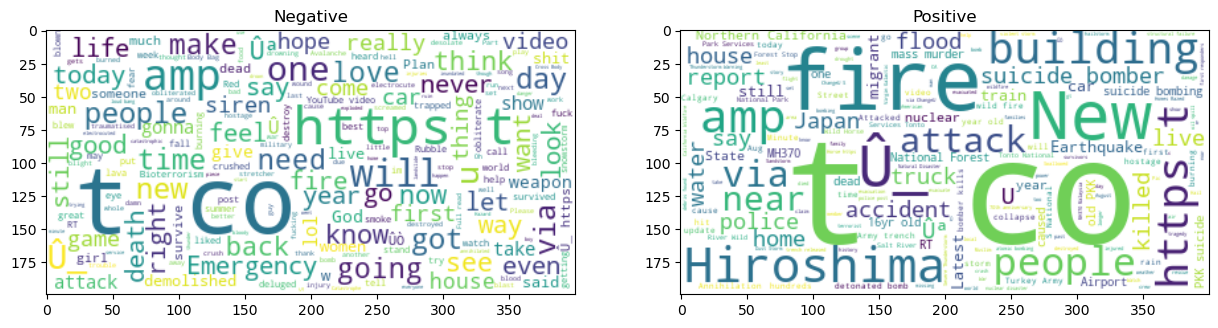

In [74]:
negative_cases = "".join(df_test2[df_test2['target'] == 0]['text'].values)
positive_cases = "".join(df_test2[df_test2['target'] == 1]['text'].values)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))

wc1 = WordCloud(background_color='white').generate(negative_cases)
wc2 = WordCloud(background_color='white').generate(positive_cases)

axs[0].imshow(wc1, interpolation='bilinear')
axs[0].set_title('Negative')
axs[1].imshow(wc2, interpolation='bilinear')
axs[1].set_title('Positive')

plt.show()

In [75]:
df_new.to_csv('submission.csv', index=False)